In [1]:
from keras.datasets import boston_housing
(train_data, train_targets),(test_data, test_targets) = boston_housing.load_data()


In [2]:
print(train_data.shape[1])

13


In [3]:
mean = train_data.mean(axis=0)
standardDeviation = train_data.std(axis=0)
# axis means it's taken along the 0 axis
train_data-=mean
train_data/=standardDeviation
test_data-=mean
test_data/=standardDeviation

In [9]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(train_data.shape[1],))) 
    # number of features = 13 = train_data.shape[1]


    model.add(layers.Dense(1, input_shape=(256,)))
    # the reason no activation function is needed because this is the output prediction, 
    # which doesn't need to and shouldn't be limited by the range of an activation function
    # it may seem that providing a relu would do no harm but in fact it may curtail training
    # efficacy for the output can no longer be negative which lowers the cost function when
    # the output is indeed negative, thus lowering training efficiency for weights producing
    # a negative output.
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    # mean square error often used for regression
    # mae stands for mean absolute error (it's what will be printed out when we train the model)
    return model

In [10]:
import numpy as np
k=4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []
all_mae_history=[]
for i in range(k):
    print('processing fold ',i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,validation_data = (val_data,val_targets),epochs=num_epochs,batch_size=1,verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_history.append(mae_history)
    print(np.mean([i for i in mae_history]))
# this is called a k-fold validation. In each fold, we choose a different set of data for validation and iterate
# through all folds, rebuilding the model in each. The reason we are doing this is the sample size is small,
# which makes validating on using a set of data inaccurate. We want to validate on all data but we also want
# to keep the validation data and training data separate. So we train the model for multiple times using different
# validation and training data for each to help us compute the average validation loss.

processing fold  0
2.136738665103912
processing fold  1
2.461000769138336
processing fold  2
2.6237743043899537
processing fold  3
2.5454486775398255


In [11]:
avg_mae_history = [np.mean([maes[i] for maes in all_mae_history]) for i in range(num_epochs)]
print([np.mean(avg_mae_history[num_epochs-10:num_epochs],axis=0)])
#print('1', end='\r')
#print('2', end='\r')
#print('3', end='\r')

[2.3396568566560747]


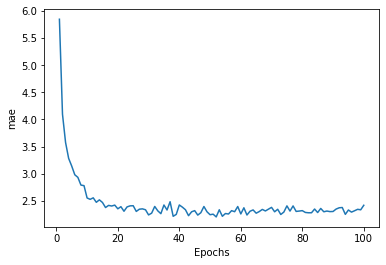

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(avg_mae_history)+1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.show()

epoch :  10  avg mae :  5.369813400506973

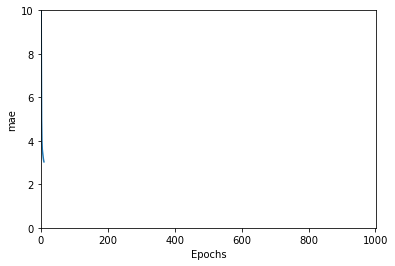

epoch :  20  avg mae :  2.679954069852829

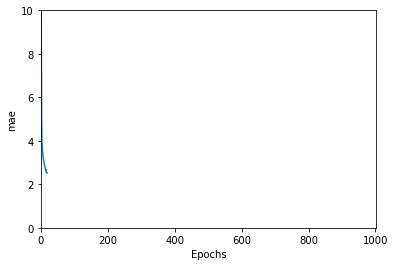

epoch :  30  avg mae :  2.3876785188913345

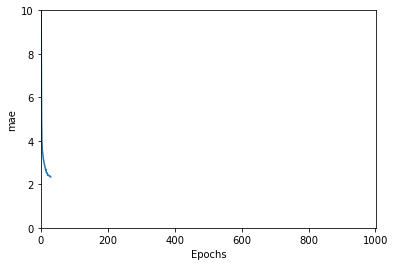

epoch :  40  avg mae :  2.3141603499650953

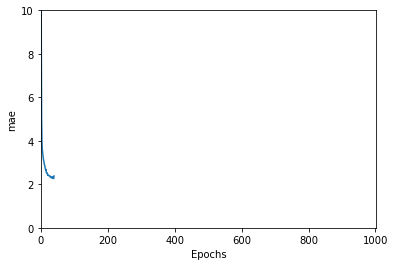

epoch :  50  avg mae :  2.2669640868902206

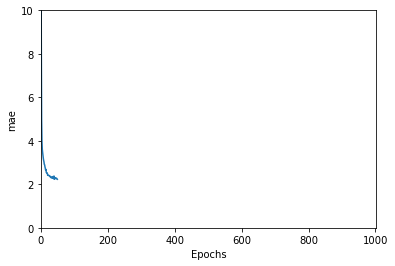

epoch :  60  avg mae :  2.260092815756798

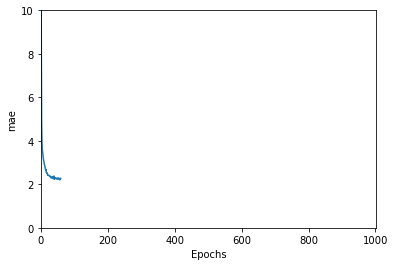

epoch :  70  avg mae :  2.253402626514435

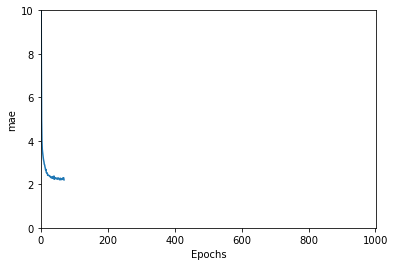

epoch :  80  avg mae :  2.2578326404094695

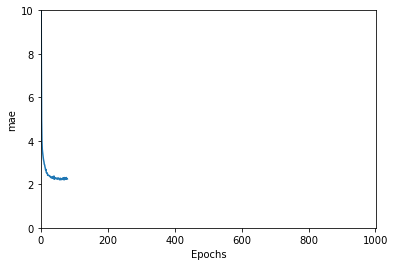

epoch :  90  avg mae :  2.242700734734535

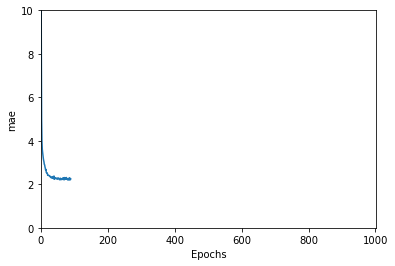

epoch :  100  avg mae :  2.240905484557152

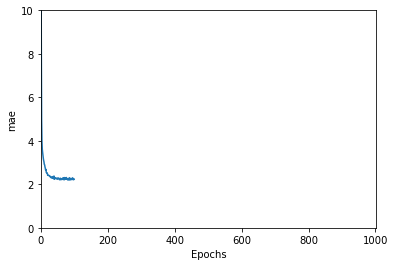

epoch :  110  avg mae :  2.2437294721603394

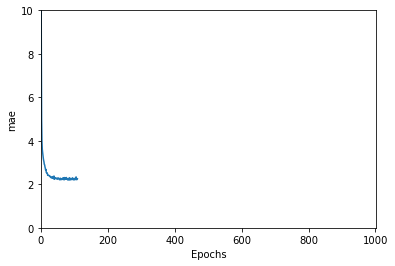

epoch :  120  avg mae :  2.2511313289403914

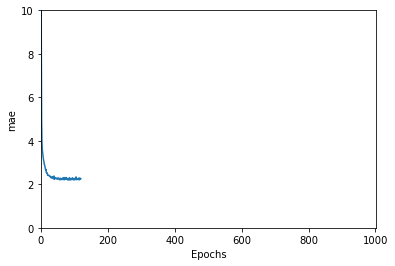

epoch :  130  avg mae :  2.258433482050896

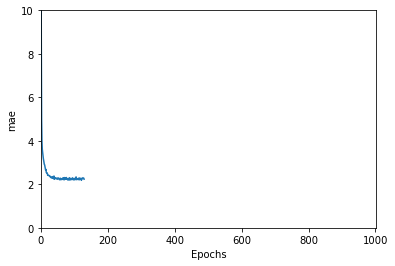

epoch :  140  avg mae :  2.262291380763054

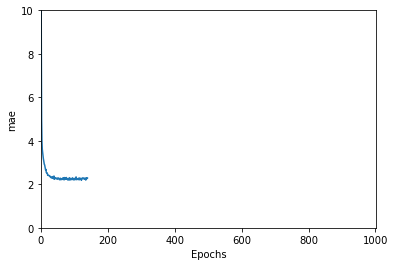

epoch :  150  avg mae :  2.2802490919828413

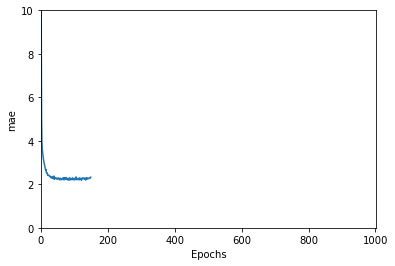

epoch :  160  avg mae :  2.2729788452386854

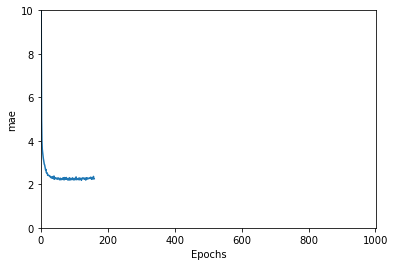

epoch :  170  avg mae :  2.2766103357076646

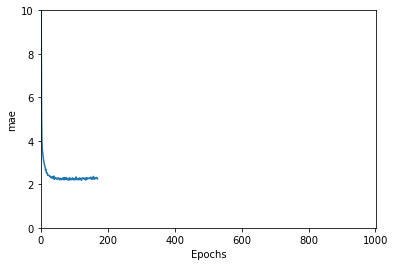

epoch :  180  avg mae :  2.3091074943542482

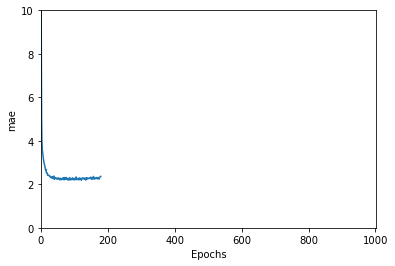

epoch :  190  avg mae :  2.3019497394561768

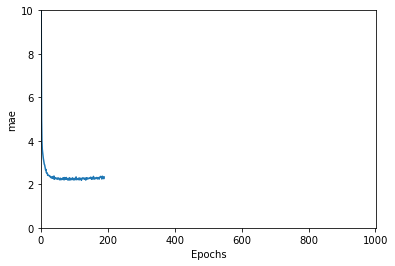

epoch :  200  avg mae :  2.293740618228912

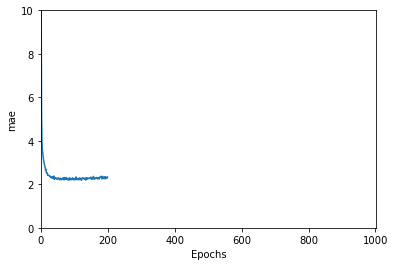

epoch :  210  avg mae :  2.287898051738739

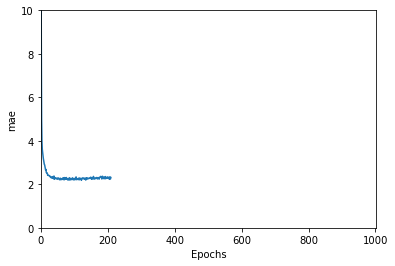

epoch :  218  mae :  2.2730779051780728

KeyboardInterrupt: 

In [14]:
# modified K-fold implementation
import matplotlib.pyplot as plt
import numpy as np

k=4
num_val_samples = len(train_data)//k
num_epochs = 1000
k_models = []
k_val_data = []
k_val_targets = []
k_partial_train_data = []
k_partial_train_targets = []
all_avgs = []
for i in range(k):
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],train_data[(i+1)*num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples],train_targets[(i+1)*num_val_samples:]],axis=0)
    
    k_val_data.append(val_data)
    k_val_targets.append(val_targets)
    k_partial_train_data.append(partial_train_data)
    k_partial_train_targets.append(partial_train_targets)
    model = build_model()
    k_models.append(model)
    
for epoch_i in range(num_epochs):
    #print('epoch: ',epoch_i+1)
    maes = []
    for i in range(k):
        k_models[i].fit(k_partial_train_data[i],k_partial_train_targets[i],epochs = 1,batch_size=4,verbose = 0)
        (mse, mae) = k_models[i].evaluate(k_val_data[i],k_val_targets[i],verbose = 0)
        maes.append(mae)
    avg_mae = np.average(maes)
    all_avgs.append(avg_mae)
    print("\repoch : ",epoch_i," mae : ",avg_mae, end="")
    if((epoch_i+1)%10==0):
        print("\repoch : ",epoch_i+1," avg mae : ",np.average(all_avgs[-10:]), end="")
        plt.xlabel('Epochs')
        plt.ylabel('mae')
        plt.xlim(0,num_epochs+1)
        plt.ylim(0,10)
        plt.plot(range(epoch_i+1), all_avgs)
        plt.show()
    


In [ ]:
# IMPORTANT:
# Hypothesis space and the trade off between the width and depth of a neural network

# to fully understand how the hypothesis space of a neural network correlates with the shape of this neural network
# there's no better way than to visualize the hypothesis space through visualizing where each sample can go in a space
# For every sample, consider each layer of the neural network as a vector where each neuron is a dimension of the 
# vector. Then since the transformation from the activated layer to a new layer involves only linear combination and
# addition of constant, it can be viewed as a linear transformation of the vector represented by the previous layer 
# in addition to a shifting by constant. On the other hand, the activation function can be viewed as an operation
# operating on each of the nodes/neurons (or independent operations on each dimension). 
# So each sample at each layer is a point in multidimensional space with 
# number of dimensions equaling the width of that layer. However, visualizing one point/sample isn't enough to see
# the hypothesis space. We must visualize all points/samples possible to do that. 
# For an input layer of n dimensions, all possible points/samples is basically an n dimensional object. So we can 
# apply the transformations described above on this object to see our hypothesis space. Specifically, let's consdier
# an example where the activation function is relu (activation function is the core in defining the hypothesis space).
# For simplicity let's consider an input of one dimension, so our object is a line. Say the first hidden layer is n
# dimensional. This will transform the line into n D space however the line will still remain a one dimensional object
# because it's a linear transformation. Now we apply the activation function which is what delinearizes it. For relu 
# increases the value in any dimension in which it's negative to 0. For example, if n=3, the line in three dimension 
# will be curbed so that the parts of it which goes to other quadrants than the first quadrant will be curbed to along
# the axial planes. This will often result in three curbs (that is, three turning points). In general, by applying a
# relu activation function to a linear object in n dimension, we are creating n turning points on this object. If our
# object was 2 dimensional, this would result in n curbs and thus n turning "points" (turning lines). This generalizes
# well to a k dimensional input object. This is what happens in the activation process of dimension extension. What
# if we are looking at dimension reduction? The same applies (the theorem about the number of curbing) but it would 
# be harder to figure out the position of curbing. 

# So the richness of the hypothesis space of a neural network can be described by the number of curbing it makes. 
# As can be seen easily from the above discussion the number of curbing made = number of hidden neurons. With this
# intuition and theorem established we can look at the trade off between width and depth of a neural network.

# Whenever we do dimension reduction we lose some amount of information. This is easily seen as we flatten a 3D object
# to 2D, we lose the info about depth. The whole point of neural network and machine learning in general is to condense
# information, thus dimensional reduction. However before we make one dimensional reduction, we should make sure our
# info is curbed enough such that the information that will be lost during the dimensional reduction is irrelevant.
# So in designing a neural network, we may not want to conduct a very drastic dimensional reduction, since the curbing
# in the previous layer may not be enough to make sure all info lost is irrelevant. Theoretically, reducing directly
# from 100D to 1D is possible since there will be 100 curbings done in 100D layer. However, this will force our model,
# in order to preserve the most important information give up a lot of info during the 100 curbings. The central idea
# is, all curbings in a dimensional reduction layer lose information, but we must reduce the dimension to a certain
# desired number of dimensions, so we want to minimize the loss of info during this curbing to retain precision. 

# Now disregarding dimensional reduction, is a deep neural network better or a wide one better? In a wide layer, many
# curbs are done simultaneously (simultaneously delinearized) which could create regularity to the model (that is, 
# there are limited number of ways in which the hypothesis space can be since there're limited ways in which we could
# curb it). So in this respect a deep neural network can have a richer hypothesis space. This is a two-edged sword.
# The regularity limits the hypothesis space but also reduces overfitting by impeding the neural network from learning
# some very peculiar features specific to the training examples. From another perspective, if we don't blow it up to 
# a high enough dimensional space, there may be some curbing that can only be done with much difficulties. 

# The other thing to be considered is how hard it is to train a network. We know that the richness of hypothesis space
# roughly equals number of hidden neurons so for two models of same number of hidden neurons, one wide another deep,
# which is easier to train? The difficulty of training depends on how many weights there are which we must tune. 
# Since the number of weights between two layers = width of layer 1 * width of layer 2. Consider two model of n*m 
# neurons where n>m, with one having n as depth m as width and the other one the reverse. the first one has O(m^2*n)
# weights while the second has O(n^2*m) weights. Obviously the first one has less weights, that is the deeper one. The
# network with less parameters to tune is intuitively easier to tune but in fact it's also slower to tune for more 
# parameters allows more parallel modifications and thus a faster gradient descent.
# However, this is not the full picture since we are not considering the defect of gradient descent: gradient 
# explosion and gradient vanishing problem, which are both more severe with a deeper network. In practice, a deep 
# network is often significantly harder to train than a shallow one, despite its potentials.

# Now let's consider a major problem in neural network: overfitting. The core issue with overfitting is that info of
# the training examples that are irrelevant with the general trend and specific to the training examples start to leak
# into neural network. Note the information capacity is not exactly equal to its hypothesis space. Hypothesis space
# means where the input vector can go in the output field and that doesn't include information about where they 
# exactly are. For example, if we map an input of n dimensional object to 1D space, hypothesis space gives the range
# of where this object can be, it doesn't give about the sparsity/density of the samples in the allowed output space.
# The information capacity is intuitively correlated with the number of tuned parameters, thus the number of weights.
# Since for two models of equal number of nodes, the wider one has more weight, it is thus more prone to overfitting.
# Note that we are speaking of the model's capacity for overfitting here not its speed for overfitting (when does it
# starts to overfit which also depends on the speed of training)

# In general, it looks like deeper networks have an upperhand, which is exactly why deeper networks a generally the 
# direction of development these days.